Measures of posterior predictive calibration (after Quality of Uncertainty Quantification, Yao et al., 2019) for regression analysis include:

**1. Average marginal log-likelihood**
$$\mathbb{E}_{(x_n,y_n)∼D} \left[\mathbb{E}_{q(W)}[p(y_n|x_n, W)]\right]$$<br>
**2. Predictive RMSE**
$$\sqrt{\frac{1}{N}\sum_{n=1}^{N}||y_n-\mathbb{E}_{q(W)}[f(x_n,W)]||_{2}^{2}}$$<br>
**3. Prediction interval coverage probability**
$$\frac{1}{N}\sum_{n=1}^{N}\mathbb{1}_{y_n\leq\hat{y}_{n}^{high}} \cdot \mathbb{1}_{y_n\geq\hat{y}_{n}^{low}} $$<br>
**4. Mean prediction interval width**
$$\frac{1}{N}\sum_{n=1}^{N}\hat{y}_{n}^{high} - \hat{y}_{n}^{low},$$<br>
where $\hat{y}_{n}^{high}$ and $\hat{y}_{n}^{low}$ are - respectively - the $97.5\%$ and $2.5\%$ percentiles of the predicted outputs for $x_n$.<br><br>
The authors of *'Accurate Uncertainties for Deep Learning'* postulate also assessing model calibration by investigating calibration plots, i.e. by binning the predictions into selected intervals (e.g. $[0, 0.1]$, $(0.1, 0.2]$, $...$), and plotting the predicted vs. the observed frequency of the dependent variable. Well calibrated models should produce calibration plots lying on a $45^\circ$ straight line. Calibration assessment based on calibration plot might be synthesized using calibration error. We thus have yet another measure for assessing the quality of uncertainty in BNN:<br>

**5. Calibration error**
$$cal(F_1, y_1, ..., F_N, y_N ) = \sum_{j=1}^m w_j \cdot (p_j − \hat{p}_j)^2$$

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Piotr.Pekala\AppData\Local\Continuum\anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
np.random.seed(2014)

In [3]:
def Make_observations(N, true_degree, true_noise):
    
    #generate N observations from a polynomial of a given 'true_degree' and std 'true_noise',
    #return x and y
    
    x = np.append(np.linspace(-2.5,-1, num=N/2),np.linspace(.0,2.5, num=N/2))
    y = x**true_degree + 2.5*np.sin(x*5) + np.random.normal(size=x.size)*true_noise
        
    return(x, y)

In [4]:
def MLE_poly(MLE_degree):
    
    #fit a polynomial of degree 'MLE_degree' using MLE
    #return set of features fot the model to be fitted on (X_train), set of fitted y and coeficients of the model
    
    poly = PolynomialFeatures(degree=MLE_degree)
    MLEtrain = poly.fit_transform(x[:, np.newaxis])
    MLEcoefs = np.polyfit(x, y, deg=MLE_degree)[::-1]
    MLEpred = MLEtrain @ MLEcoefs
    
    return(MLEpred, MLEcoefs)

In [5]:
N = 200
true_degree = 3
true_noise = 1.5
MLE_degree = 3

x,y = Make_observations(N, true_degree, true_noise)
MLEpred, MLEcoefs = MLE_poly(MLE_degree)

C:\Users\Piotr.Pekala\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


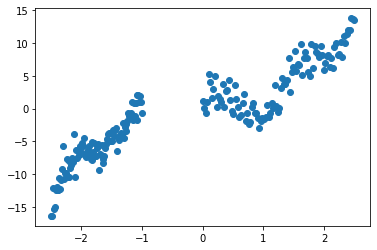

In [6]:
plt.scatter(x,y);

In [7]:
def Make_bayesian_poly(prior_degree, prior_coef_sigma, prior_noise):

    # fit bayesian polynomial regression
    # return trace
    
    poly = PolynomialFeatures(degree=prior_degree)
    X_train = poly.fit_transform(x[:, np.newaxis])
    
    with pm.Model() as model:
        coefs = pm.Normal('coefs', mu=0, sigma=prior_coef_sigma, shape=prior_degree+1)
        y_pred = pm.math.dot(X_train, coefs)
        y_obs = pm.Normal('y_obs', mu=y_pred, sigma=prior_noise, observed=y)
        trace = pm.sample(500, tune=500)
        
    return(X_train, trace)

In [8]:
prior_degree = 2
prior_coef_sigma = 10
prior_noise = 3
X_train, trace = Make_bayesian_poly(prior_degree, prior_coef_sigma, prior_noise)
posterior_coefs = trace['coefs'].T

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coefs]
Sampling 4 chains: 100%|████████████████████████████████████████████████████████| 4000/4000 [01:17<00:00, 51.60draws/s]


In [9]:
def simulate_posterior_predictive(thetas = posterior_coefs, x = X_train, noise=prior_noise):
    
    #generate samples from the posterior predictive using a prior standard deviation of the noise
    #return posterior predicitve
    
    posterior_predictive = X_train @ posterior_coefs
    posterior_predictive += np.random.normal(loc=0, scale=noise, size=posterior_predictive.shape)
    
    return(posterior_predictive)

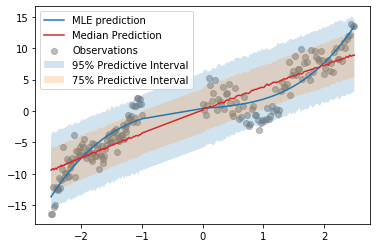

In [10]:
# Simulate the posterior predictive
x_test = np.linspace(x.min(), x.max(), num=N)
posterior_predictive = simulate_posterior_predictive(x = x_test, thetas = posterior_coefs, noise = prior_noise)

# Plot the posterior predictive
low, low75, mid, high75, high = np.percentile(posterior_predictive, [2.5, 12.5, 50, 87.5, 97.5], axis=1)
plt.scatter(x, y, color='tab:grey', alpha=0.5, label='Observations')
plt.fill_between(x, low, high, alpha=0.2, label='95% Predictive Interval')
plt.fill_between(x, low75, high75, alpha=0.2, label='75% Predictive Interval')
plt.plot(x, MLEpred, color='tab:blue', label='MLE prediction')
plt.plot(x, mid, color='tab:red', label='Median Prediction')
plt.legend();

In [11]:
# forward definiton
forward = lambda X_train, thetas, noise: simulate_posterior_predictive(X_train , thetas, noise)

In [12]:
def percentiles(y, X_train, thetas = posterior_coefs, noise = prior_noise):
    
    #calculate percentiles for calibration error
    #return empirical and theoretical percentiles
     
    post_pred = forward(X_train, thetas, noise)
    
    N = post_pred.shape[1]
    T = y.shape[0]

    percent_y  = np.sum(post_pred <= y.reshape((T,1)), axis=1) / N
    
    p_hat = np.sum(percent_y.reshape(-1, T) <= percent_y.reshape(T, -1), axis=1) / T
    
    return(percent_y, p_hat)

In [13]:
predicted_percentiles, empirical_percentiles = percentiles(y, X_train, thetas=posterior_coefs)

In [14]:
def assess_calibration():

    #calculate a set of different calibration metrics
        
    cal_error  = np.sum((predicted_percentiles-empirical_percentiles)**2)
    
    RMSE = np.sqrt(np.sum((y-np.mean(posterior_predictive, axis=1))**2)/N)
    
    MPIW95 = np.mean(high-low)
    MPIW75 = np.mean(high75-low75)
       
    coverage_prob95 = [False] * N
    for i in range(N):
        coverage_prob95[i] = (y[i]>=low[i] and y[i]<=high[i])
    PICP95 = np.sum(coverage_prob95)/N
    
    coverage_prob75 = [False] * N
    for i in range(N):
        coverage_prob75[i] = (y[i]>=low75[i] and y[i]<=high75[i])
    PICP75 = np.sum(coverage_prob75)/N
        
    return(cal_error, RMSE, MPIW95, MPIW75, PICP95, PICP75)

In [15]:
assess_calibration()

(0.22772825000000002,
 2.758642989322439,
 11.835909526595627,
 6.963638867821356,
 0.975,
 0.785)

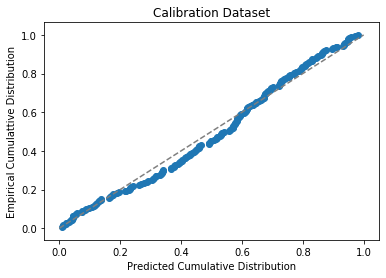

In [16]:
plt.scatter(predicted_percentiles, empirical_percentiles)
plt.plot([0, 1], [0, 1], color='tab:grey', linestyle='--')
plt.xlabel('Predicted Cumulative Distribution')
plt.ylabel('Empirical Cumulattive Distribution')
plt.title('Calibration Dataset');